 #Volatility Forecasting 

📥 2. Import Libraries & Set Up

In [2]:
!pip install arch


  Obtaining dependency information for arch from https://files.pythonhosted.org/packages/6b/a7/20b3f209b55a862f6ff0ec508d158a12c6e7eb9b62cfa839822eafcc0214/arch-7.2.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/927.1 kB ? eta -:--:--
   - -------------------------------------- 30.7/927.1 kB ? eta -:--:--
   --- ------------------------------------ 92.2/927.1 kB 1.3 MB/s eta 0:00:01
   --------- ------------------------------ 225.3/927.1 kB 2.0 MB/s eta 0:00:01
   -------------------- ------------------- 471.0/927.1 kB 2.7 MB/s eta 0:00:01
   ---------------------------------------  911.4/927.1 kB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 927.1/927.1 kB 3.7 MB/s eta 0:00:00


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import sqlite3
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats


3. Fetch Stock Data via API

In [4]:
# First, install yfinance if you haven't yet
!pip install yfinance --quiet

import yfinance as yf

# Choose your stock ticker, e.g. Apple (AAPL)
ticker = "AAPL"

# Download 1 year of daily stock data
data = yf.download(ticker, period="1y", interval="1d")

# Show first few rows
print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2024-05-21  191.454636  191.832856  190.031284  190.200491  42309400
2024-05-22  190.011368  191.922444  189.384311  191.375001  34648500
2024-05-23  186.010086  190.110903  185.761250  190.090992  51005900
2024-05-24  189.095657  189.692870  187.164685  187.941069  36294600
2024-05-28  189.105606  192.101589  188.219750  190.618520  52280100


🔍 5. Exploratory Data Analysis
Convert prices to daily returns

Plot returns

Plot ACF & PACF of squared returns



In [5]:
# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())



Missing values per column:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


In [7]:
print(data.columns)


MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [9]:
# Extract the Close price for AAPL
close_prices = data[('Close', 'AAPL')]

In [10]:
# Calculate simple returns
data['Return'] = close_prices.pct_change()


In [11]:
# Calculate log returns
data['LogReturn'] = np.log(close_prices / close_prices.shift(1))


In [12]:
# Drop NA values
data = data.dropna()

In [13]:
# Show first few rows of returns
print(data[['Return', 'LogReturn']].head())

Price         Return LogReturn
Ticker                        
Date                          
2024-05-22 -0.007538 -0.007567
2024-05-23 -0.021058 -0.021283
2024-05-24  0.016588  0.016452
2024-05-28  0.000053  0.000053
2024-05-29  0.001579  0.001578


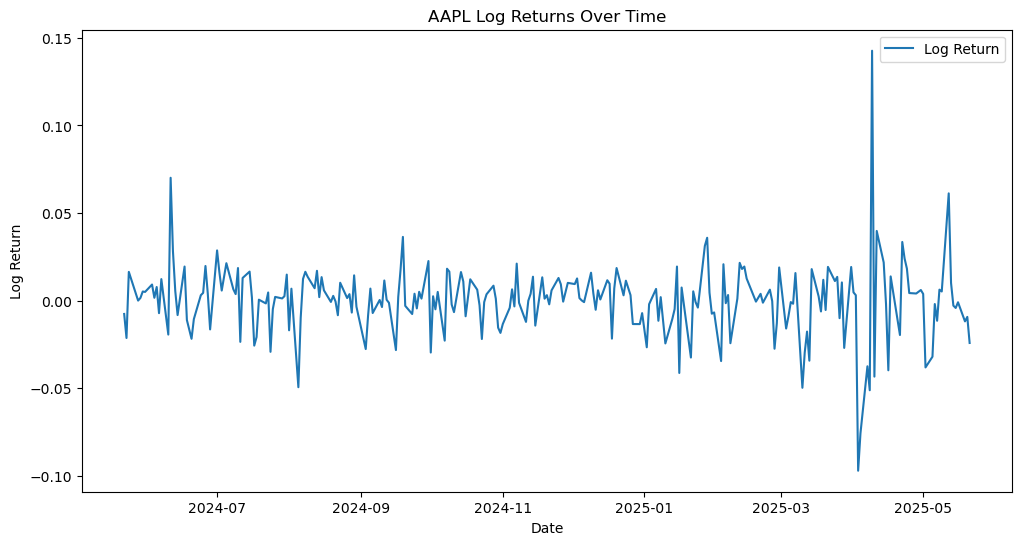

In [14]:
# Plot Log Returns
plt.figure(figsize=(12,6))
plt.plot(data.index, data['LogReturn'], label='Log Return')
plt.title("AAPL Log Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()

Calculate key stats on returns:

In [16]:
mean_return = data['Return'].mean()
std_return = data['Return'].std()
skew_return = data['Return'].skew()
kurt_return = data['Return'].kurtosis()

print(f"Mean Return: {mean_return:.6f}")
print(f"Volatility (Std Dev): {std_return:.6f}")
print(f"Skewness: {skew_return:.6f}")
print(f"Kurtosis: {kurt_return:.6f}")

Mean Return: 0.000427
Volatility (Std Dev): 0.020822
Skewness: 1.037815
Kurtosis: 13.391949


Mean Return (0.000427) — On average, daily return is about 0.04%, which makes sense for a large stable stock like Apple.

Volatility (Std Dev = 0.0208) — Daily return standard deviation of about 2%, showing typical daily fluctuations.

Skewness (1.038) — Positive skew; returns have a longer right tail (some big positive return days).

Kurtosis (13.39) — High kurtosis means fat tails; more extreme returns than a normal distribution, common in financial returns.

In [19]:
ticker = 'AAPL'

# Calculate returns using .loc to avoid the warning
data.loc[:, ('Return', ticker)] = data[('Close', ticker)].pct_change()
data.loc[:, ('LogReturn', ticker)] = np.log(data[('Close', ticker)] / data[('Close', ticker)].shift(1))

In [20]:
# Drop NaN rows
data = data.dropna()

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


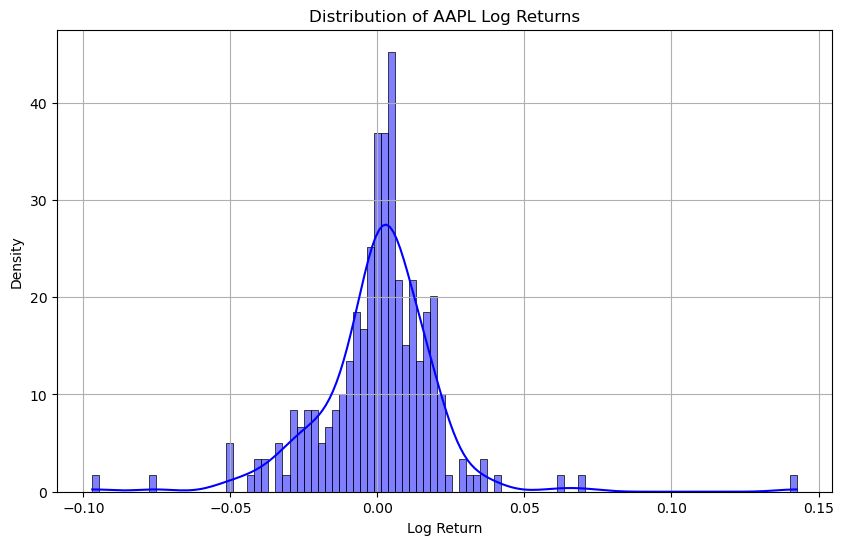

In [22]:
# Plot the distribution of log returns
plt.figure(figsize=(10,6))
sns.histplot(data[('LogReturn', ticker)], bins=100, kde=True, color='blue', stat='density')
plt.title(f"Distribution of {ticker} Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.grid(True)
plt.show()

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Density')

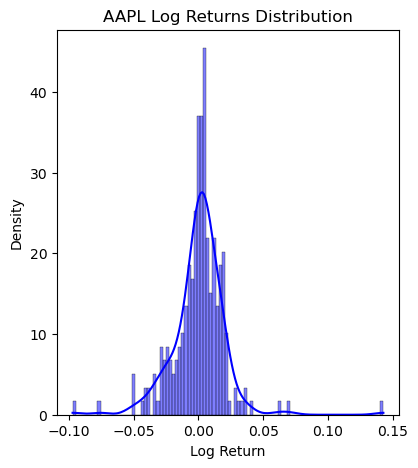

In [24]:
ticker = 'AAPL'

# Calculate returns using .loc to avoid warnings
data.loc[:, ('Return', ticker)] = data[('Close', ticker)].pct_change()
data.loc[:, ('LogReturn', ticker)] = np.log(data[('Close', ticker)] / data[('Close', ticker)].shift(1))

# Drop NaN rows
data = data.dropna()

log_returns = data[('LogReturn', ticker)]

# Plot histogram with KDE
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(log_returns, bins=100, kde=True, color='blue', stat='density')
plt.title(f"{ticker} Log Returns Distribution")
plt.xlabel("Log Return")
plt.ylabel("Density")

Text(0.5, 1.0, 'AAPL Log Returns QQ Plot')

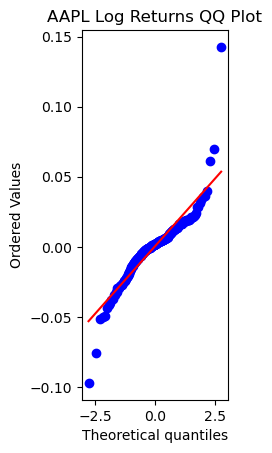

In [25]:
# QQ plot for normality
plt.subplot(1, 3, 2)
stats.probplot(log_returns, dist="norm", plot=plt)
plt.title(f"{ticker} Log Returns QQ Plot")

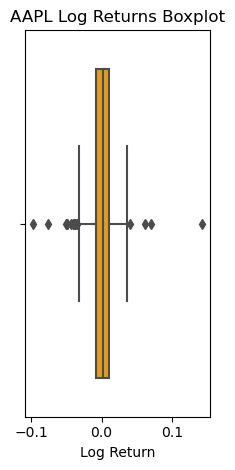

In [30]:
# Boxplot for outliers
plt.subplot(1, 3, 3)
sns.boxplot(x=log_returns, color='orange')
plt.title(f"{ticker} Log Returns Boxplot")
plt.xlabel("Log Return")
# Adjust layout and display all plots
plt.tight_layout()
plt.show()

1. Recall the Log Return Series

In [31]:
log_returns = data[('LogReturn', 'AAPL')].dropna()

In [32]:
confidence_level = 0.95
var_95 = np.percentile(log_returns, (1 - confidence_level) * 100)
print(f"Historical VaR (95%): {var_95:.5f}")


Historical VaR (95%): -0.03227


📈 6. Fit GARCH Model

In [34]:
from arch import arch_model

# Drop NaNs from log returns
log_returns = data[('LogReturn', 'AAPL')].dropna()

# Fit a GARCH(1,1) model
model = arch_model(log_returns * 100, vol='GARCH', p=1, q=1, mean='Zero', dist='normal')
garch_fit = model.fit(disp='off')

# Summary of the model
print(garch_fit.summary())

                         Zero Mean - GARCH Model Results                         
Dep. Variable:     ('LogReturn', 'AAPL')   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.004
Vol Model:                         GARCH   Log-Likelihood:               -503.893
Distribution:                     Normal   AIC:                           1013.79
Method:               Maximum Likelihood   BIC:                           1024.33
                                           No. Observations:                  248
Date:                   Thu, May 22 2025   Df Residuals:                      248
Time:                           01:10:55   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.6516      0.784  

Plot the conditional volatility

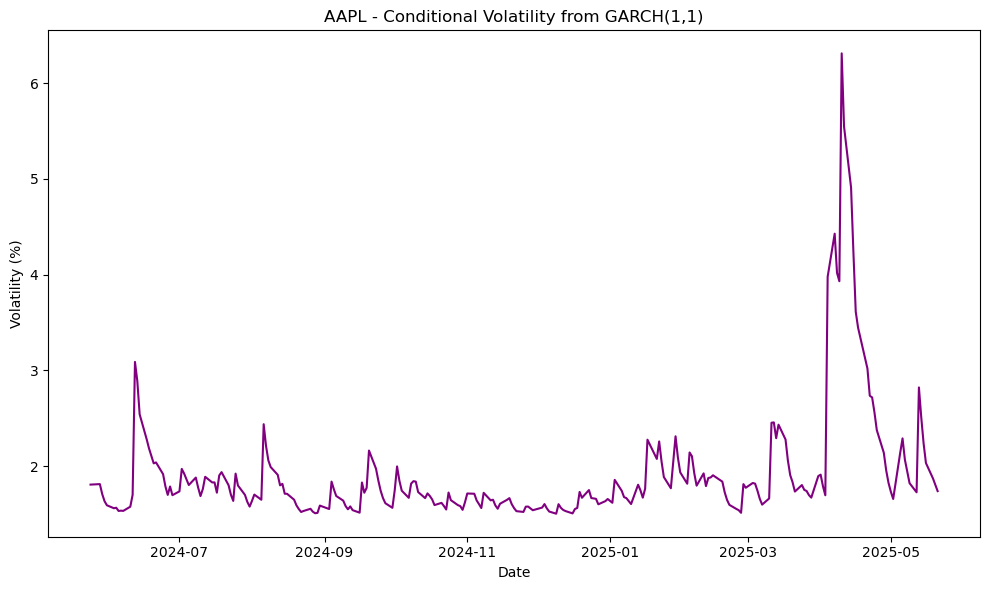

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(garch_fit.conditional_volatility, color='purple')
plt.title('AAPL - Conditional Volatility from GARCH(1,1)')
plt.ylabel('Volatility (%)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


Forecast Volatility for Next 5 Days

In [38]:
# Forecast 5 days ahead using the fitted model 'garch_fit'
forecast_horizon = 5
forecast = garch_fit.forecast(horizon=forecast_horizon)

# Extract forecasted variance for the last available date and compute volatility (standard deviation)
forecast_variance = forecast.variance.values[-1, :]
forecast_volatility = np.sqrt(forecast_variance)

# Print forecasted volatilities for the next 5 days
for i in range(forecast_horizon):
    print(f"Day {i+1} Forecasted Volatility (%): {forecast_volatility[i]:.5f}")

Day 1 Forecasted Volatility (%): 1.88552
Day 2 Forecasted Volatility (%): 1.89835
Day 3 Forecasted Volatility (%): 1.90894
Day 4 Forecasted Volatility (%): 1.91769
Day 5 Forecasted Volatility (%): 1.92492


Plot the forecasted volatility


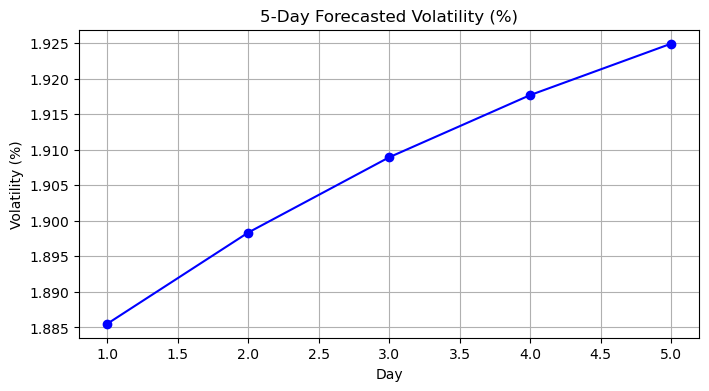

In [39]:
import matplotlib.pyplot as plt

days = range(1, forecast_horizon + 1)

plt.figure(figsize=(8,4))
plt.plot(days, forecast_volatility, marker='o', linestyle='-', color='blue')
plt.title('5-Day Forecasted Volatility (%)')
plt.xlabel('Day')
plt.ylabel('Volatility (%)')
plt.grid(True)
plt.show()


Calculate 1-day Value at Risk (VaR) at 95% confidence using forecasted volatility:

In [40]:
from scipy.stats import norm

z_95 = norm.ppf(0.05)  # -1.645

# 1-day VaR in percent
VaR_1d = z_95 * forecast_volatility[0]
print(f"1-Day 95% VaR (%): {VaR_1d:.4f}")


1-Day 95% VaR (%): -3.1014


Calculate multi-day VaR assuming independent returns:

In [41]:
import numpy as np

# sqrt of days for scaling volatility
VaR_multi_day = z_95 * forecast_volatility * np.sqrt(days)

for day, var in zip(days, VaR_multi_day):
    print(f"{day}-Day 95% VaR (%): {var:.4f}")


1-Day 95% VaR (%): -3.1014
2-Day 95% VaR (%): -4.4159
3-Day 95% VaR (%): -5.4385
4-Day 95% VaR (%): -6.3086
5-Day 95% VaR (%): -7.0799


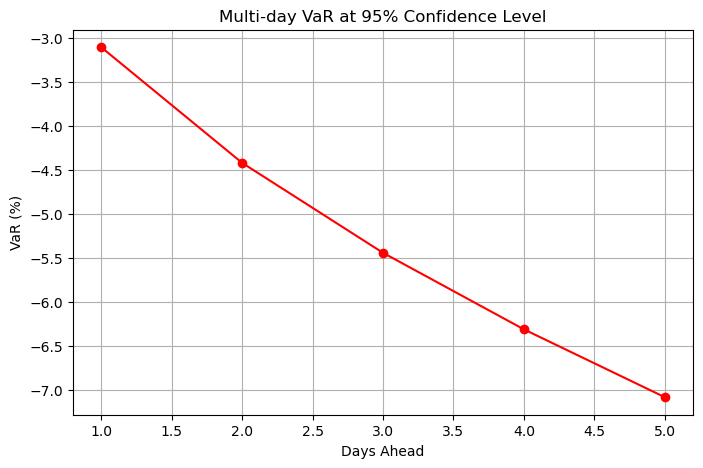

In [42]:
import matplotlib.pyplot as plt

days = [1, 2, 3, 4, 5]
VaR_values = [-3.1014, -4.4159, -5.4385, -6.3086, -7.0799]

plt.figure(figsize=(8,5))
plt.plot(days, VaR_values, marker='o', linestyle='-', color='red')
plt.title('Multi-day VaR at 95% Confidence Level')
plt.xlabel('Days Ahead')
plt.ylabel('VaR (%)')
plt.grid(True)
plt.show()


📉 7. Calculate Volatility
Plot conditional volatility

Annualize volatility: multiply daily volatility by √252

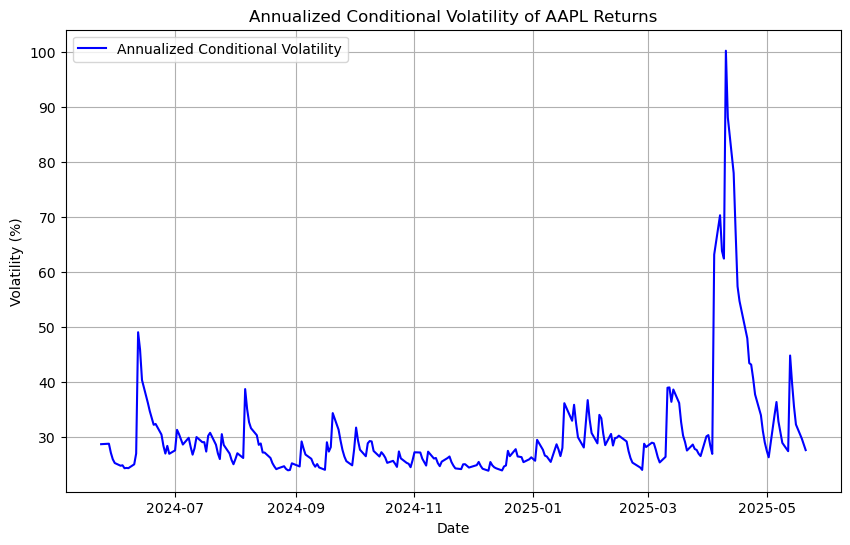

In [43]:
# Extract conditional volatility from fitted model (daily % volatility)
cond_vol = garch_fit.conditional_volatility  # daily volatility in percentage

# Annualize volatility (√252 trading days per year)
annualized_vol = cond_vol * np.sqrt(252)

plt.figure(figsize=(10,6))
plt.plot(annualized_vol, color='blue', label='Annualized Conditional Volatility')
plt.title('Annualized Conditional Volatility of AAPL Returns')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.show()


📊 8. Visualize Results
Time series of returns vs volatility

Residual plots

Model diagnostics

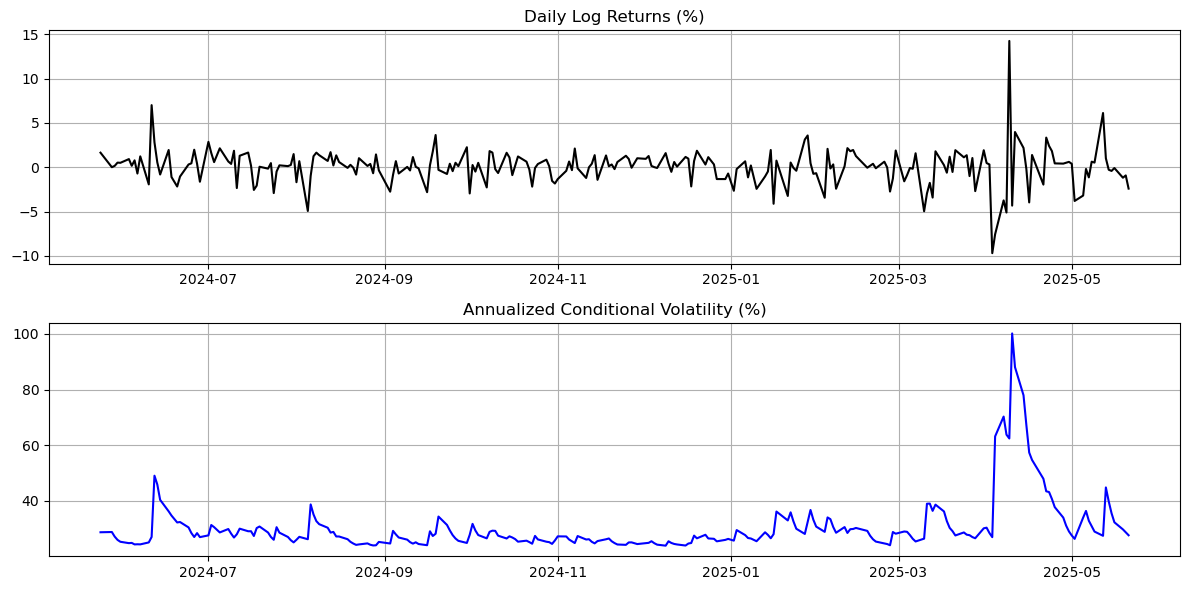

In [44]:
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(log_returns.index, log_returns * 100, color='black')
plt.title('Daily Log Returns (%)')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(annualized_vol.index, annualized_vol, color='blue')
plt.title('Annualized Conditional Volatility (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

Residual Plot and Diagnostics

Check standardized residuals to see if the model captured volatility clustering:

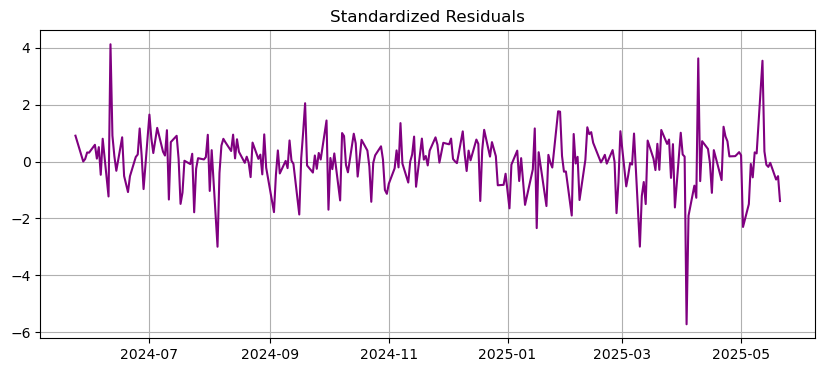

In [45]:
std_resid = garch_fit.std_resid

plt.figure(figsize=(10,4))
plt.plot(std_resid, color='purple')
plt.title('Standardized Residuals')
plt.grid(True)
plt.show()


📦model diagnostics like:

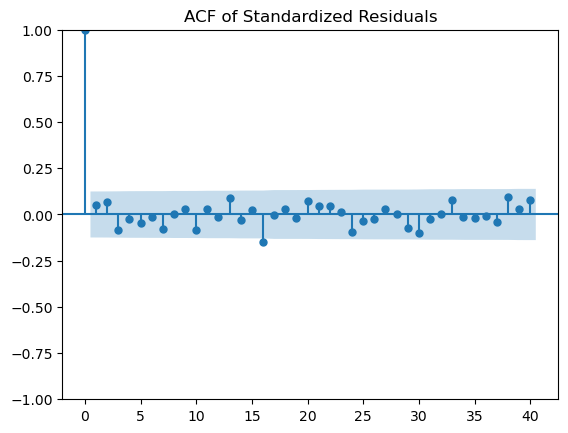

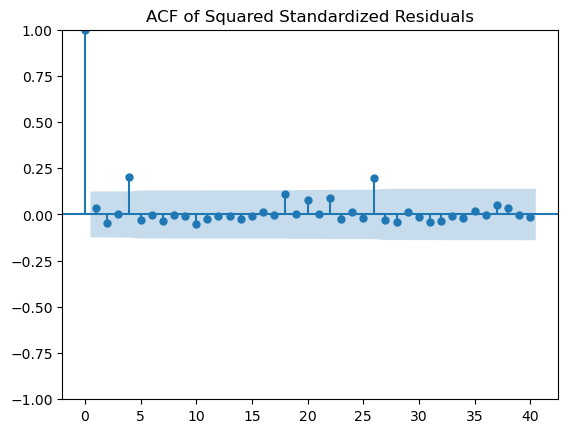

In [46]:
from statsmodels.graphics.tsaplots import plot_acf

# ACF of standardized residuals
plot_acf(std_resid, lags=40)
plt.title('ACF of Standardized Residuals')
plt.show()

# ACF of squared standardized residuals (to check for remaining ARCH effects)
plot_acf(std_resid**2, lags=40)
plt.title('ACF of Squared Standardized Residuals')
plt.show()


Done